In [ ]:
stars.xls

Populating the interactive namespace from numpy and matplotlib
IF USING PYTHON 3, DO NOT USE QUOTES.
What is the filename of the data to be analyzed?: 20150827_CutSites.xlsx

How would you like the data to be analyzed?
"1" Parse data automatically using only the Full Name and Values.
"2" Parse data manually by specifying columns.
Your answer: 2
We found the following columns:
"1" mean FL1
"2" normalized GFP
"3" Site

What is the number of the column that you would like to occupy the x-axis?: 3

What is the number of the column that you would like to occupy the y-axis?: 1

If this is a time series, enter the number of the column that holds the genes to be compared
Otherwise, enter nothing and press "Enter": 
We found the following mean FL1 values.
"1" ARS1014a
"2" ARS1021b
"3" ARS1114a
"4" ARS1414a
"5" ARS1622b
"6" ARS208a
"7" ARS308a
"8" ARS416b
"9" ARS607b
"10" ARS720a
"11" BY4742
"12" YPRCd15c(Ndel)
"13" cany1

Enter the numbers of the columns you would like to plot, separated by a c

/Users/leodespaux/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


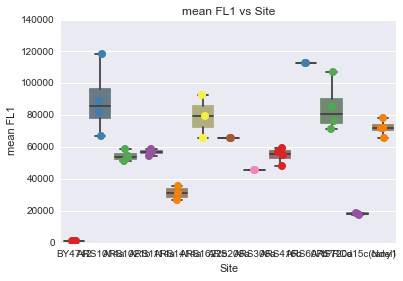

In [3]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import math
from pandas import ExcelWriter

# Parses the excel file manually 
def parseExcelManual(filename):
    df = pd.read_excel(filename)
    print("We found the following columns:")
    counter = 0
    
    colDict = {}
    for value in df.columns.values:
        counter += 1
        print("\"" + str(counter) + "\"" " " + value)
        colDict[str(counter)] = value

    print("")
    xcol = input("What is the number of the column that you would like to occupy the x-axis?: ")
    xcol = colDict[xcol]
    print("")
    ycol = input("What is the number of the column that you would like to occupy the y-axis?: ")
    ycol = colDict[ycol]
    print("")
    print("If this is a time series, enter the number of the column that holds the genes to be compared")
    zcol = input("Otherwise, enter nothing and press \"Enter\": ")

    if not zcol:
        manualEdit(df, xcol, ycol)
    else:
        zcol = colDict[zcol]
        manualTimeEdit(df, xcol, ycol, zcol)

# Manual data selection for plotting.
def manualEdit(df, xcol, ycol):
    title = ycol + " vs " + xcol
    
    # making a new series, where xcol is the label, and then makes correspondence
    # between the label and the value
    d = {xcol: df[xcol], ycol: df[ycol]}
    
    # then put it into a data frame
    reorg = pd.DataFrame(data=d)
    
    # dropna removes anything thats without a value (NaN)
    reorg = reorg.dropna(axis = 0)
    
    # flips/trasnposes to make it easier to work with 
    reorg = reorg.pivot_table(ycol, xcol, reorg.index)
    reorg = reorg.T

    print("We found the following " + ycol + " values.")

    counter = 0
    valueDict = {}
    for value in reorg.columns.values:
        counter += 1
        print("\"" + str(counter) + "\"" " " + value)
        valueDict[str(counter)] = value
    print("")
    print("Enter the numbers of the columns you would like to plot, separated by a comma and space. Press enter to plot all.")
    answer = input("Your answer: ")
    splitNumbers = answer.split(", ")
    
    splitAnswer = []
    for number in splitNumbers: 
        splitAnswer.append(valueDict[number])

    # Handle removing columns and also reordering the columns.
    if answer != "":

        tempReorg = reorg.copy(deep=True)
        for index, value in reorg.iteritems():
            tempReorg.drop(index, axis = 1, inplace = True)

        for columnName in splitAnswer:
            tempReorg[columnName] = reorg[columnName]

        reorg = tempReorg

    box = input("Do you want a boxplot? (y/n): ")
    normalize = input("Do you want to normalize the y-axis? (y/n): ")
    if normalize == 'y':
        # amax is the max value of the values, fills NaN with zeroes
        reorg = reorg / np.amax(reorg.fillna(0).values)
        title = title + " Normalized"
        
    if box == "y":
        print("What kind of boxplot do you want?")
        print("\"1\" for a quartile boxplot.")
        print("\"2\" for a standard deviation boxplot.")
        boxStyle = input("Your answer: ")

        if boxStyle == "1":
            makeBoxplotQuartile(reorg)
        else:
            makeBoxplotDeviation(reorg)

    sns.stripplot(data=reorg, size = 7, jitter = True, palette = sns.color_palette("Set1", n_colors=8, desat=.9))

    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.title(title)
    plt.gca().set_ylim(bottom = 0)

    exportExcel(reorg);

    plt.show()

# Manual data selection for a time plot. 
def manualTimeEdit(df, xcol, ycol, zcol):

    title = ycol + " vs " + xcol

    d = {'Gene': df[zcol], 'Time': df[xcol], 'Values': df[ycol]}
    df = pd.DataFrame(data=d)

    # Drop any nonsensical rows
    df = df.dropna(axis = 0, how='any')

    print("We found the following " + zcol + " values.")
    counter = 0
    valueDict = {}
    for value in df['Gene']:
        if value not in valueDict.values():
            counter += 1
            print("\"" + str(counter) + "\"" " " + value)
            valueDict[str(counter)] = value

    print("Enter the numbers of the columns you would like to plot, separated by a comma and space. Press \"Enter\" to plot all.")
    answer = input("Your answer: ")
    splitNumbers = answer.split(", ")
    
    splitAnswer = []
    for number in splitNumbers: 
        splitAnswer.append(valueDict[number])

    axDefined = False
    if answer != "":
        for value in valueDict.values():
            if value not in splitAnswer:
                df = df[df.Gene != value]
            else:
                tempdf = df[df['Gene'] == value]
                tempdf.columns = ['Gene', 'Time', value]
                if axDefined == False:
                    axDefined = True
                    ax = tempdf.plot(x = 'Time', y = [value], label = value)
                    tempdf.plot(x = 'Time', y = [value], kind = 'scatter', ax = ax)
                else:
                    tempdf.plot(x = 'Time', y = [value], ax = ax, label = value) 
                    tempdf.plot(x = 'Time', y = [value], kind = 'scatter', ax = ax)

    plt.title(title)
    plt.ylabel(ycol)
    plt.xlabel(xcol)
    plt.gca().set_ylim(bottom = 0)
    plt.show()

# Parses the excel condition data file and organizes it into a dataframe.
def parseExcelCondition(filename):
    df = pd.read_excel(filename, index = False)
    # Placeholder columns
    df['Date'] = ""
    df['Gene'] = "a"
    df['Sample'] = "b"
    df['Condition'] = "c"
    df2 = pd.DataFrame()

    # Iterates through, extracting data from the full name. 
    for i in df.iterrows():
        _, series = i;

        fullName = series[0]
        splitName = fullName.split("_")
        date = splitName[0]
        gene = splitName[1]
        sample = splitName[2]
        condition = splitName[3]

        series.replace(series.get('Date'), date, inplace = True)
        series.replace(series.get('Gene'), gene, inplace = True)
        series.replace(series.get('Sample'), sample, inplace = True)
        series.replace(series.get('Condition'), condition, inplace = True)
        df2 = df2.append(series)

    # Reorganizes the data into something more readable, without the full name.
    df2 = df2[['Gene', 'Date', 'Sample', 'Condition', 'Values']]

    return df2

# Parses the excel condition data file and organizes it into a dataframe.
def parseExcelTime(filename):
    df = pd.read_excel(filename, index = False)
    # Placeholder columns
    df['Date'] = ""
    df['Gene'] = "a"
    df['Sample'] = "b"
    df['Time'] = 0
    df2 = pd.DataFrame()

    # Iterates through, extracting data from the full name. 
    for i in df.iterrows():
        _, series = i;

        fullName = series[0]
        splitName = fullName.split("_")
        date = splitName[0]
        gene = splitName[1]
        sample = splitName[2]
        time = splitName[3]

        # Convert time into a universal unit (min)
        timeNumber = int(re.findall(r'\d+', time)[0])
        
        if "sec" in time:
            time = timeNumber / 60
        elif "min" in time:
            time = timeNumber
        elif "h" or "hr" in time:
            time = timeNumber * 60
        elif "day" in time:
            time = timeNumber * 60 * 24
        elif "week" in time:
            time = timeNumber * 60 * 24 * 7
        elif "year" in time:
            time = timeNumber * 60 * 24 * 365

        series.replace(series.get('Date'), date, inplace = True)
        series.replace(series.get('Gene'), gene, inplace = True)
        series.replace(series.get('Sample'), sample, inplace = True)
        series.replace(series.get('Time'), time, inplace = True)


        df2 = df2.append(series)

    # Reorganizes the data into something more readable, without the full name.
    df2 = df2[['Gene', 'Date', 'Sample', 'Time', 'Values']]

    return df2
# Generates a scatter plot with optional boxplots for the various genes/conditions
# in a single figure. 
def conditionPlot(data):

    data = data.pivot_table('Values', ['Sample'], ['Gene', 'Condition'])
    answer = input("Do you want a boxplot to go with your data? (y/n): ")
    normalize = input("Would you like to normalize the y-axis? (y/n): ")
    if normalize == 'y':
        data = data / np.amax(data.fillna(0).values)
        
    if answer == "y":
        print("What kind of boxplot do you want?")
        print("\"1\" for a quartile boxplot.")
        print("\"2\" for a standard deviation boxplot.")
        boxStyle = input("Your answer: ")

        if boxStyle == "1":
            makeBoxplotQuartile(data)
        else:
            makeBoxplotDeviation(data)

        makeBoxplot(data)
        # Iterate through the columns, generating data to form the boxplot.

    sns.stripplot(data=data, size = 7, jitter = True, palette = sns.color_palette("Set1", n_colors=8, desat=.9))
    ylabel = input("What should the y-axis label be?: ")

    plt.ylabel(ylabel)
    plt.xlabel('Gene/Condition')
    exportExcel(data);
    plt.show()

# Generates a (time) line plot with the 95% confidence interval shaded
# for each gene.
def timePlotLine(data):
    normalize = input("Would you like to normalize the y-axis? (y/n): ")
    geneNamesDict = {}
    for _, row in data.iterrows():
        geneNamesDict[row['Gene']] = 1

    data = data.pivot_table('Values', ['Sample'], ['Gene', 'Time'])

    geneList = geneNamesDict.keys()
    ylabel = input("What should the y-axis label be?: ")

    print(geneList)
    counter = 1

    for key in geneList:
    
        plt.figure(counter)
        tempTable = data[key]
        tempTable = tempTable.T
        tempTable = tempTable.dropna(axis=1, how='any')
        if normalize == 'y':
            tempTable = tempTable / np.amax(tempTable.values)

        tempTable['Time'] = tempTable.index
        tempTable = pd.melt(tempTable, id_vars='Time')[['Time','value']]
        sns.regplot(x='Time',y='value',data=tempTable,scatter=True)
        plt.title(key)
        plt.ylabel(ylabel)
        plt.xlabel('Time(min)')
        counter += 1
    plt.show()

# Generates a (time) scatter plot with optional (specialized) box plots
# in a separate figure for each gene.
def timePlotScatter(data):
    geneNamesDict = {}
    for _, row in data.iterrows():
        geneNamesDict[row['Gene']] = 1

    data = data.pivot_table('Values', ['Sample'], ['Gene', 'Time'])
    geneList = geneNamesDict.keys()

    counter = 1
    box = input("Do you want a boxplot for each timepoint? (y/n): ")

    if (box == 'y'):
        print("What kind of boxplot do you want?")
        print("\"1\" for a quartile boxplot.")
        print("\"2\" for a standard deviation boxplot.")
        boxStyle = input("Your answer: ")
    
    normalize = input("Would you like to normalize the y-axis? (y/n): ")
    ylabel = input("What should the y-axis label be?: ")

    for key in geneList:
        title = key
        plt.figure(counter)
        tempTable = data[key]
        if normalize == 'y':
            tempTable = tempTable / np.amax(tempTable.values)
            title = key + " Normalized"
        if box == "y":
            if boxStyle == "1":
                makeBoxplotQuartile(tempTable)
            else:
                makeBoxplotDeviation(tempTable)
           
        sns.stripplot(data=tempTable, size = 7, jitter = True, palette = sns.color_palette("Set1", n_colors=8, desat=.9))
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel('Time(min)')
        counter += 1
    exportExcel(data)
    plt.show()

# Determines what kind of data is being processed.
# Returns true if the data is time data and false if condition data.
def isTime(filename):
    df = pd.read_excel(filename, index=False)
    for _,series in df.iterrows():
        splitName = series[0].split("_")
        parameter = splitName[3]
        break;

    return any(char.isdigit() for char in parameter)

# Generates a traditional boxplot.
def makeBoxplotQuartile(tempTable):
    sns.boxplot(data=tempTable, palette = sns.color_palette("Set1", n_colors=8, desat=.3))

# Generates a specialized boxplot in which the whiskers represent data
# based on standard deviation and the mean rather than on quartiles and 
# the median.  
def makeBoxplotDeviation(tempTable):
    # making separate data frame with mean, std, etc, over std(0), which is
    # the category name
    stdevSeries = tempTable.std(0)
    meanSeries = tempTable.mean(0)
    boxTable = tempTable.copy(deep=True)
    boxTable = boxTable.T.drop(boxTable.T, axis = 1)
    boxTable = boxTable.T

    # Iterate through the rows to find the psuedo data for boxplot.
    for index, value in stdevSeries.iteritems():
        mean = meanSeries[index]
        stdev = stdevSeries[index]
        # make a separate data frame containing mean, std dev etc
        tempSer = pd.Series(data=[mean-2*stdev,mean-stdev,mean-stdev/2,mean,mean+stdev/2,mean+stdev,mean+2*stdev],
                            index = [1, 2, 3, 4, 5, 6, 7])
        boxTable[index] = tempSer
    sns.boxplot(data=boxTable, palette = sns.color_palette("Set1", n_colors=8, desat=.3))

def exportExcel(tempTable):

    toExport = input("Do you want to export statistical data to an excel file? (y/n): ")    
    
    if toExport == 'y':
        filename = input("What should the filename be? (Do not include extension): ")

        if ".xls" not in filename:
            filename = filename + ".xls"

        stdevSeries = tempTable.std(0)
        meanSeries = tempTable.mean(0)
        boxTable = tempTable.copy(deep=True)
        boxTable = boxTable.T.drop(boxTable.T, axis = 1)
        boxTable = boxTable.T

        outTable = tempTable.copy(deep=True)
        finalSeries = pd.DataFrame()

        for index, value in stdevSeries.iteritems():
            mean = meanSeries[index]
            stdev = stdevSeries[index]
            # make a separate data frame containing mean, std dev etc
            tempSer = pd.Series(data=[stdev, mean],
                                index = ["Standard Deviation", "Mean"])
            boxTable[index] = tempSer

        for index, value in tempTable.iteritems():
            outTable[index].dropna(inplace=True)
            tempSeries = outTable[index].reset_index(drop=True)
            finalSeries[index] = tempSeries

        finalSeries = finalSeries.append(boxTable)
        writer = ExcelWriter(filename)

        finalSeries.to_excel(writer,'Sheet1')
    
        writer.save()

# Initial user interface.
def askUser():
    print("IF USING PYTHON 3, DO NOT USE QUOTES.")

    filename = input("What is the filename of the data to be analyzed?: ")

    print("")
    print("How would you like the data to be analyzed?")
    print("\"1\" Parse data automatically using only the Full Name and Values.")
    print("\"2\" Parse data manually by specifying columns.")
    
    parser = input("Your answer: ")

    if parser == "1":
        if isTime(filename):
            data = parseExcelTime(filename)
            answer = input("Do you want a linear regression for your data? (y/n): ")
            if answer == "n":
                timePlotScatter(data)
            else:
                timePlotLine(data)
        else:
            data = parseExcelCondition(filename)
            conditionPlot(data)
    else:
        parseExcelManual(filename)

askUser()


# Testing Files:
# conditionData.xlsx
# timeData.xlsx
# leodata2.xlsx